In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
import seaborn as sns


# Global figure settings & functions

In [3]:
# === Global Plot Settings ===
TITLE_FONTSIZE = 12
LABEL_FONTSIZE = 12
TICK_FONTSIZE = 10
LEGEND_FONTSIZE = 11
BAR_COLORS = ['blue', 'orange']
EFFECT_COLORS = ['red', 'cyan']
HIST_COLOR = 'grey'
ALPHA_BAR = 0.5
ALPHA_HIST = 0.5
XLIM_EFFECT = [-1, 1]

LINE_ALPHA = 0.3
LINE_WIDTH = 2

mat_input_folder="../mat_data/"
save_path = "../saved_figures/"
if not os.path.exists(save_path):
    os.makedirs(save_path)


In [4]:
def serr(x, dim=0):
    """Calculate the standard error of the mean."""
    s = np.std(x, axis=dim, ddof=1)  # Standard deviation
    n = x.shape[dim]  # Number of samples
    return s / np.sqrt(n)

In [5]:
def preprocess_effect_data(lr):
    """Preprocess data for effect size calculation."""
    transformation_matrix = np.array([[-1, -1, 1, 1], [-1, 1, -1, 1]]).T
    f = np.dot(lr, transformation_matrix)
    mf = np.mean(f, axis=0)
    ef = serr(f)
    return mf, ef, f[:, 0], f[:, 1]  # bs, bv

def plot_bar(data_mean, data_se=None, ylabel='', xlabel='', legend_title='', 
                title=None, ylim=None, show_legend=False, show_error=True, save_path=None):
    labels = ['Small', 'Large']
    x = np.arange(len(labels))
    width = 0.35

    fig, ax = plt.subplots(figsize=(3.5, 3))

    # Left bars
    ax.bar(
        x - width / 3, data_mean[:2], width / 2,
        yerr=data_se[:2] if (show_error and data_se is not None) else None,
        color=BAR_COLORS[0], label='Small'
    )

    # Right bars
    ax.bar(
        x + width / 3, data_mean[2:], width / 2,
        yerr=data_se[2:] if (show_error and data_se is not None) else None,
        color=BAR_COLORS[1], label='Large'
    )

    ax.set_xlabel(xlabel, fontsize=LABEL_FONTSIZE)
    ax.set_ylabel(ylabel, fontsize=LABEL_FONTSIZE)
    ax.set_xticks(x)
    ax.set_xticklabels(labels, fontsize=TICK_FONTSIZE)
    ax.tick_params(axis='y', labelsize=TICK_FONTSIZE)

    if title:
        ax.set_title(title, fontsize=TITLE_FONTSIZE)
    if ylim:
        ax.set_ylim(ylim)

    if show_legend:
        ax.legend(title=legend_title, fontsize=LEGEND_FONTSIZE, title_fontsize=LEGEND_FONTSIZE)

    ax.grid(False)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

def plot_effect_size(mf, ef, bs, bv, save_path=None):
    fig, ax = plt.subplots(figsize=(8, 3))
    np.random.seed(42)

    for bsi, bvi in zip(bs, bv):
        y_coords = np.array([1, 2]) + np.random.randn(2) * 0.05
        ax.plot([bsi, bvi], y_coords, color='gray', alpha=0.3, linewidth=0.5)
        ax.scatter([bsi], [y_coords[0]], color='black', s=1)
        ax.scatter([bvi], [y_coords[1]], color='black', s=1)

    # Mean bars
    ax.barh(0.7, mf[0], xerr=ef[0], color=EFFECT_COLORS[0], alpha=ALPHA_BAR, height=0.2, label='True Stochasticity')
    ax.barh(2.3, mf[1], xerr=ef[1], color=EFFECT_COLORS[1], alpha=ALPHA_BAR, height=0.2, label='True Volatility')

    # Aesthetics
    ax.axvline(0, color='black', linestyle='--', linewidth=1)
    ax.set_yticks([1, 2])
    ax.set_yticklabels(['True \nStochasticity', 'True \nVolatility'], fontsize=LABEL_FONTSIZE)
    ax.tick_params(axis='y', length=0)
    ax.set_xlabel('Effect Size', fontsize=LABEL_FONTSIZE)
    ax.set_xlim(XLIM_EFFECT)
    ax.set_ylim([0.3, 2.7])
    ax.grid(False)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()


In [6]:
def get_signals(fname_suffix, mat_input_folder="../mat_data/"):
    """Load the .mat file and extract signals."""
    file_path = os.path.join(mat_input_folder, 'pfhmm_'+fname_suffix+'.mat')
    mat_data = loadmat(file_path)  # Replace with the actual path to the .mat file
    # Extract vol (it will be a numpy object array from the cell array)
    vol = mat_data['vol_'+fname_suffix]  # shape will be (50, 1)
    # Convert the cell array (each cell is a 100x4 matrix) into a 3D numpy array (100x4x50)
    vol_signals = np.stack([vol[i, 0] for i in range(vol.shape[0])], axis=-1)
    # Extract sto and convert it to a 3D numpy array
    sto = mat_data['sto_'+fname_suffix]  # shape will be (50, 1)
    sto_signals = np.stack([sto[i, 0] for i in range(sto.shape[0])], axis=-1)
    
    return {'vol': vol_signals, 'sto': sto_signals}

def bootstrap_sem_median(data, num_bootstrap=1000):
    """Bootstrap SEM for median. Data shape: (n_trials, n_subjects)."""
    n_trials, n_subjects = data.shape
    boot_medians = np.zeros((n_trials, num_bootstrap))

    for i in range(num_bootstrap):
        for trial in range(n_trials):
            sample = np.random.choice(data[trial, :], size=n_subjects, replace=True)
            boot_medians[trial, i] = np.nanmedian(sample)

    return np.nanstd(boot_medians, axis=1)

def plot_with_bootstrap_sem(ax, data, color, label, num_bootstrap=1000):
    """Plot median ± bootstrapped SEM."""
    median = np.nanmedian(data, axis=1)
    sem = bootstrap_sem_median(data, num_bootstrap)
    ax.plot(median, color=color, label=label, linewidth=LINE_WIDTH)
    ax.fill_between(range(len(median)), median - sem, median + sem,
                    color=color, alpha=LINE_ALPHA)

def plot_dynamics_grid(subplot_config, save_path=None):
    """
    General 2x2 grid plotter based on subplot config.

    subplot_config: list of 4 dicts (row-wise order: top-left to bottom-right), each with keys:
        - 'title': str, title of the subplot
        - 'ylabel': str, label for y-axis
        - 'lines': list of dicts with:
            - 'data': np.ndarray (trials x subjects)
            - 'color': line color
            - 'label': line label
        - 'legend_title': str (optional)
    """
    fig, axes = plt.subplots(2, 2, figsize=(10, 6))

    # Group subplots into top and bottom rows
    top_indices = [0, 1]
    bottom_indices = [2, 3]

    def get_shared_ylim(indices):
        all_medians = []
        for i in indices:
            for line in subplot_config[i]['lines']:
                all_medians.append(np.nanmedian(line['data'], axis=1))
        ymin = min(np.min(m) for m in all_medians) - 0.03
        ymax = max(np.max(m) for m in all_medians) + 0.03
        return ymin, ymax

    # Shared y-limits per row
    top_ylim = get_shared_ylim(top_indices)
    bottom_ylim = get_shared_ylim(bottom_indices)

    for i, ax in enumerate(axes.flat):
        config = subplot_config[i]
        ylim = top_ylim if i in top_indices else bottom_ylim

        # Plot lines
        for line in config['lines']:
            plot_with_bootstrap_sem(ax, line['data'], color=line['color'], label=line['label'])

        # Labels & Title
        ax.set_title(config['title'], fontsize=TITLE_FONTSIZE)
        if i in bottom_indices:
            ax.set_xlabel("Trial", fontsize=LABEL_FONTSIZE)
        ax.set_ylabel(config['ylabel'], fontsize=LABEL_FONTSIZE)
        ax.set_ylim(ylim)
        ax.tick_params(axis='both', labelsize=TICK_FONTSIZE)
        ax.grid(False)

        if 'legend_title' in config:
            ax.legend(
                title=config['legend_title'],
                fontsize=LEGEND_FONTSIZE,
                title_fontsize=LEGEND_FONTSIZE
            )

    plt.tight_layout()
    plt.subplots_adjust(hspace=0.4, wspace=0.3)     
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

## Figure 2A (Time series)

In [7]:
# Load hidden state and observation data
file_path = os.path.join(mat_input_folder, "sim_timeseries.mat")
data = loadmat(file_path)
print(data.keys())  # List variables in the .mat file
hidden_state = data['hidden_state']
# print(hidden_state)
obs_df = pd.DataFrame(data['outcome'])
# print(obs_df)
# true_vol = [0.025, 0.1, 0.025, 0.1]
# true_sto = [0.125, 0.125, 0.25, 0.25]

dict_keys(['__header__', '__version__', '__globals__', 'hidden_state', 'outcome'])


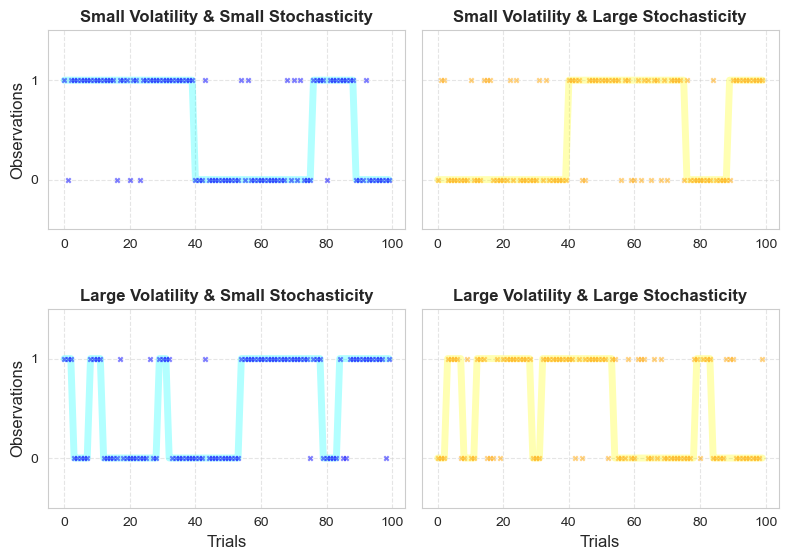

In [8]:
# Common plot styling
plot_kwargs = dict(linestyle='solid', linewidth=5, alpha=0.3)
scatter_kwargs = dict(marker='x', s=10, zorder=3, alpha=0.5)
grid_kwargs = dict(axis='both', linestyle='--', alpha=0.5)

# Subplot settings
titles = [
    'Small Volatility & Small Stochasticity',
    'Small Volatility & Large Stochasticity',
    'Large Volatility & Small Stochasticity',
    'Large Volatility & Large Stochasticity'
]

hidden_state_indices = [0, 2, 1, 3]
obs_colors = ['blue', 'orange', 'blue', 'orange']
line_colors = ['cyan', 'yellow', 'cyan', 'yellow']

# Create figure and subplots
fig, axs = plt.subplots(2, 2, figsize=(8, 6), sharex=False, sharey=True)

# Flatten the axes for easier looping
axs = axs.flatten()

for i, ax in enumerate(axs):
    # Plot line
    ax.plot(obs_df.index, hidden_state[:, hidden_state_indices[i]],
            color=line_colors[i], **plot_kwargs)
    
    # Scatter observed data
    ax.scatter(obs_df.index, obs_df[hidden_state_indices[i]],
               color=obs_colors[i], **scatter_kwargs)

    # Title and axis
    ax.set_title(titles[i], fontsize=TITLE_FONTSIZE, fontweight='bold')
    ax.set_ylim(-0.5, 1.5)
    ax.set_yticks([0, 1])
    ax.tick_params(axis='x', labelsize=TICK_FONTSIZE)
    ax.tick_params(axis='y', labelsize=TICK_FONTSIZE)
    ax.grid(**grid_kwargs)

    # X and Y labels where appropriate
    if i in [2, 3]:  # Bottom row
        ax.set_xlabel('Trials', fontsize=LABEL_FONTSIZE)
    if i in [0, 2]:  # Left column
        ax.set_ylabel('Observations', fontsize=LABEL_FONTSIZE)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.subplots_adjust(hspace=0.4)  # Adjust this value as needed
plt.savefig(save_path + "Figure2A_obs_timeseries.png", dpi=300, bbox_inches='tight')
plt.show()

## Figure 2B (HMM simulation learning rate)

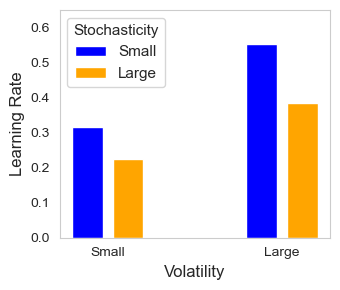

In [9]:
# Load .mat file
file_path = os.path.join(mat_input_folder, "hmm_sim.mat")
data = loadmat(file_path)  # Replace with the actual path to the .mat file
b = data['b_true']
lr = b[:, 0:4]

# Preprocess data for learning rate
mean_lr = np.mean(lr, axis=0)
serr_lr = serr(lr)
# Plot 1: Learning rate coefficients
plot_bar(mean_lr, serr_lr, ylabel='Learning Rate', xlabel='Volatility', legend_title='Stochasticity', title=None, ylim=(0,0.65), show_legend=True, show_error=False, save_path=save_path + "Figure2B_hmm_sim_lr.png")

# # Effect size
# mf, ef, bs, bv = preprocess_effect_data(lr)
# # Plot 2: Effect size
# plot_effect_size(mf, ef, bs, bv)
# plot_effect_size_with_distribution(mf, ef, bs, bv)


## Figure 3BCD (Particle Filter healthy simulation)

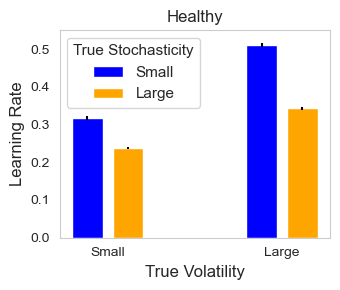

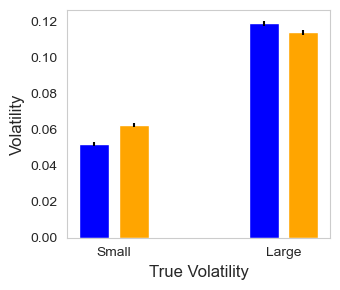

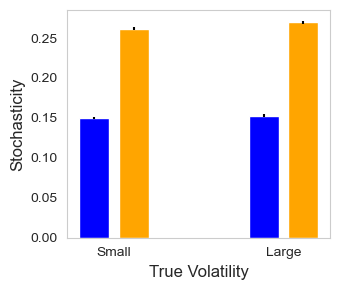

In [10]:
# Load the .mat file
file_path = os.path.join(mat_input_folder, "pfhmm_healthy.mat")
data = loadmat(file_path)
lr_healthy = data['lr_healthy']
m_vol_healthy = data['m_vol_healthy']
m_sto_healthy = data['m_sto_healthy']

data_mean = np.mean(lr_healthy, axis=0)
data_se = serr(lr_healthy)
plot_bar(data_mean, data_se, ylabel='Learning Rate', xlabel='True Volatility', ylim=(0, 0.55), title='Healthy', show_legend=True, legend_title='True Stochasticity', save_path=save_path + "Figure4D_pf_sim_lr.png")

data_mean = np.mean(m_vol_healthy, axis=0)
data_se = serr(m_vol_healthy)
plot_bar(data_mean, data_se, ylabel='Volatility', xlabel='True Volatility', save_path=save_path + "Figure3C_pf_sim_vol.png")

data_mean = np.mean(m_sto_healthy, axis=0)
data_se = serr(m_sto_healthy)
plot_bar(data_mean, data_se, ylabel='Stochasticity', xlabel='True Volatility', save_path=save_path + "Figure3D_pf_sim_sto.png")

## Figure 3EFGH (Particle Filter healthy simulation signal dynamics)


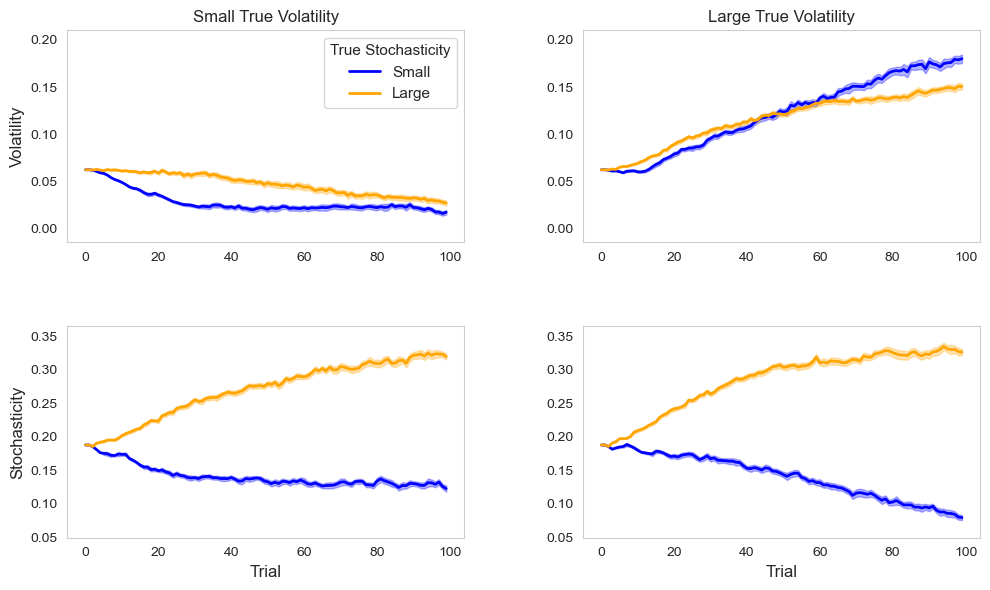

In [11]:
signals = get_signals('healthy')
# signals['sto'][:,0,:], signals['sto'][:,2,:], # sto_small_smallvol, sto_large_smallvol,
# signals['sto'][:,1,:], signals['sto'][:,3,:], # sto_small_largevol, sto_large_largevol,
# signals['vol'][:,0,:], signals['vol'][:,1,:], # vol_small_smallsto, vol_large_smallsto,
# signals['vol'][:,2,:], signals['vol'][:,3,:]  # vol_small_largesto, vol_large_largesto
plot_dynamics_grid([
    {
        'title': "Small True Volatility",
        'ylabel': "Volatility",
        'lines': [
            {'data': signals['vol'][:, 0, :], 'color': "blue", 'label': "Small"},
            {'data': signals['vol'][:, 2, :], 'color': "orange", 'label': "Large"},
        ],
        'legend_title': 'True Stochasticity'
    },
    {
        'title': "Large True Volatility",
        'ylabel': "",
        'lines': [
            {'data': signals['vol'][:, 1, :], 'color': "blue", 'label': "Small"},
            {'data': signals['vol'][:, 3, :], 'color': "orange", 'label': "Large"},
        ]
    },
    {
        'title': "",
        'ylabel': "Stochasticity",
        'lines': [
            {'data': signals['sto'][:, 0, :], 'color': "blue", 'label': "Small"},
            {'data': signals['sto'][:, 2, :], 'color': "orange", 'label': "Large"},
        ]
    },
    {
        'title': "",
        'ylabel': "",
        'lines': [
            {'data': signals['sto'][:, 1, :], 'color': "blue", 'label': "Small"},
            {'data': signals['sto'][:, 3, :], 'color': "orange", 'label': "Large"},
        ]
    }
], 
save_path=save_path + "Figure3EFGH_pf_sim_healthy_dynamics.png")


## Figure 4EFGH (Particle Filter lesion simulation)

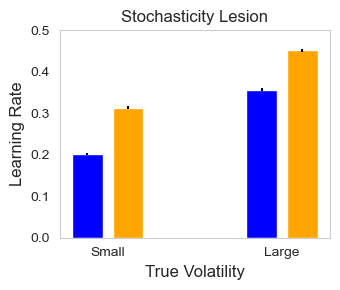

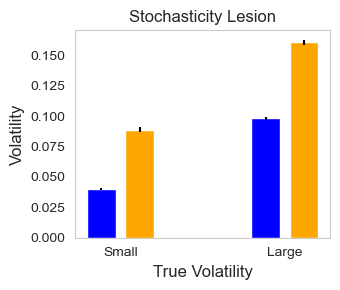

In [12]:
file_path = os.path.join(mat_input_folder, "pfhmm_smal.mat")
data = loadmat(file_path)
lr_smal = data['lr_smal']
m_vol_smal = data['m_vol_smal']
m_sto_smal = data['m_sto_smal']

data_mean = np.mean(lr_smal, axis=0)
data_se = serr(lr_smal)
plot_bar(data_mean, data_se, ylabel='Learning Rate', xlabel='True Volatility', title='Stochasticity Lesion', ylim=(0, 0.5), show_legend=False, save_path=save_path + "Figure4E_pf_sim_sles_lr.png")

data_mean = np.mean(m_vol_smal, axis=0)
data_se = serr(m_vol_smal)
plot_bar(data_mean, data_se, ylabel='Volatility', xlabel='True Volatility', title='Stochasticity Lesion', save_path=save_path + "Figure4G_pf_sim_sles_vol.png")

# data_mean = np.mean(m_sto_smal, axis=0)
# data_se = serr(m_sto_smal)
# plot_bar(data_mean, data_se, ylabel='Stochasticity', xlabel='True Volatility', title='Stochasticity Lesion')

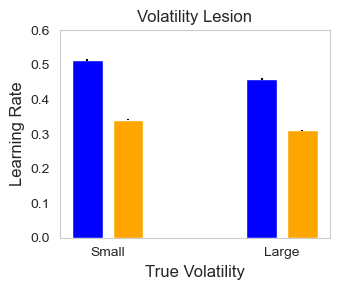

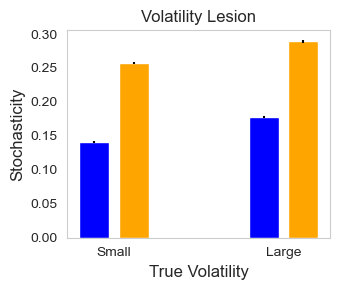

In [13]:
file_path = os.path.join(mat_input_folder, "pfhmm_vmal.mat")
data = loadmat(file_path)
lr_vmal = data['lr_vmal']
m_vol_vmal = data['m_vol_vmal']
m_sto_vmal = data['m_sto_vmal']

data_mean = np.mean(lr_vmal, axis=0)
data_se = serr(lr_vmal)
plot_bar(data_mean, data_se, ylabel='Learning Rate', xlabel='True Volatility', title='Volatility Lesion', ylim=(0, 0.6), show_legend=False, save_path=save_path + "Figure4F_pf_sim_vles_lr.png")

# data_mean = np.mean(m_vol_vmal, axis=0)
# data_se = serr(m_vol_vmal)
# plot_bar(data_mean, data_se, ylabel='Volatility', xlabel='True Volatility', title='Volatility Lesion')

data_mean = np.mean(m_sto_vmal, axis=0)
data_se = serr(m_sto_vmal)
plot_bar(data_mean, data_se, ylabel='Stochasticity', xlabel='True Volatility', title='Volatility Lesion', save_path=save_path + "Figure4H_pf_sim_vles_sto.png")

## FIgure 5BCD (Actual data HMM learning rate, PFHMM learning rate, and HMM effect size)

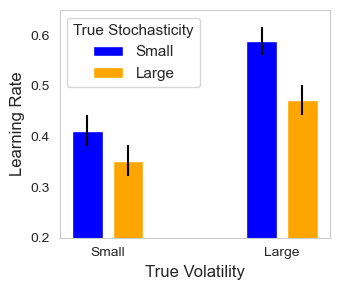

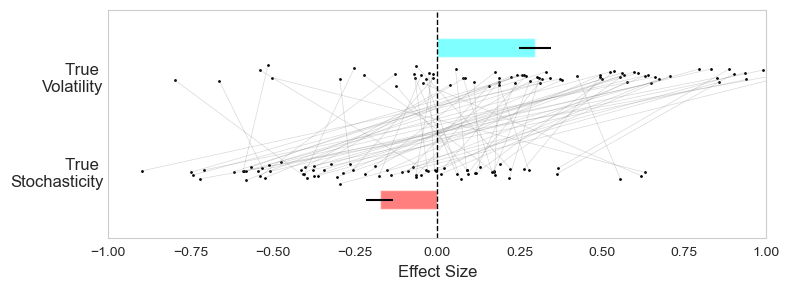

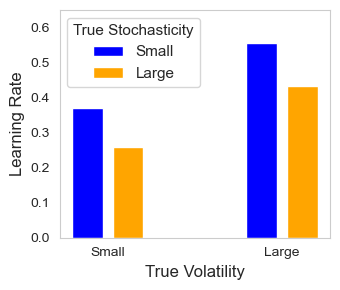

In [14]:
# Load .mat file
file_path = os.path.join(mat_input_folder, "hmm_params.mat")
data = loadmat(file_path)  # Replace with the actual path to the .mat file
lr = data['lr']

# Preprocess data for learning rate
mean_lr = np.mean(lr, axis=0)
serr_lr = serr(lr)
# Plot 1: Learning rate coefficients
plot_bar(mean_lr, serr_lr, ylabel='Learning Rate', xlabel='True Volatility', legend_title='True Stochasticity', title=None, ylim=(0.2,0.65), show_legend=True, save_path=save_path + "Figure5B_hmm_actual_lr.png")

# Effect size
mf, ef, bs, bv = preprocess_effect_data(lr)
# Plot 2: Effect size
plot_effect_size(mf, ef, bs, bv, save_path=save_path + "Figure5D_hmm_actual_effect_size.png")

file_path = os.path.join(mat_input_folder, "pfhmm_sealion_timeseries.mat")
data = loadmat(file_path)  # Replace with the actual path to the .mat file
lr_pfhmm = data['lr_pfhmm']
# Preprocess data for learning rate
mean_lr = np.mean(lr_pfhmm, axis=0)
serr_lr = serr(lr_pfhmm)
# Plot 1: Learning rate coefficients
plot_bar(mean_lr, serr_lr, ylabel='Learning Rate', xlabel='True Volatility', legend_title='True Stochasticity', title=None, ylim=(0,0.65), show_legend=True, save_path=save_path + "Figure5C_pfhmm_actual_lr.png")

## Figure 6 (RT)

In [15]:
file_path = os.path.join(mat_input_folder, "response_time_analysis.mat")
data = loadmat(file_path)  # Replace with the actual path to the .mat file
b_rt = data['b_rt']
regressor_names = data['regressor_names']
# If regressor_names is a MATLAB cell array, convert it to a Python list of strings.
if isinstance(regressor_names, np.ndarray):
    # MATLAB cell arrays loaded via loadmat are sometimes object dtype arrays.
    regressor_names = [str(item[0]) if isinstance(item, (list, np.ndarray)) else str(item)
                       for item in regressor_names.ravel()]
print(regressor_names)
print(b_rt.shape)

['intercept', 'y_std', 'y_mean', 'vol', 'sto', 'accuracy']
(73, 6)


/Users/Kary/anaconda3/envs/hmm/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/Kary/anaconda3/envs/hmm/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


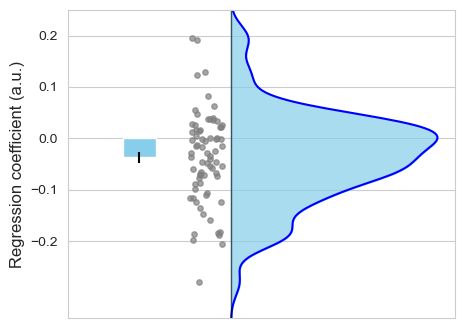

In [16]:
# -----------------------------------------
# Statistical analysis on regression values
# -----------------------------------------
n_subjects = b_rt.shape[0]
# Compute the mean and standard error for each coefficient
mean_eff = np.mean(b_rt, axis=0)
serr_eff = np.std(b_rt, axis=0, ddof=1) / np.sqrt(n_subjects)

# -------------------------------------------
# Prepare data for plotting the 'y_std' regressor
# (second coefficient; MATLAB is 1-indexed, Python 0-indexed)
# -------------------------------------------
col_index = 1  # second column
mb = mean_eff[col_index]   # mean for 'y_std'
eb = serr_eff[col_index]   # standard error for 'y_std'
b_dots = b_rt[:, col_index]  # distribution of coefficients across subjects

# --------------------------
# Plotting: Create a raincloud plot
# --------------------------
y_label = 'Regression coefficient (a.u.)'

# Create figure and axis. 
# Adjust figsize as needed to obtain the proper aspect ratio.
fig, ax = plt.subplots(figsize=(5,4))

# (a) Plot the KDE (the “cloud”) vertically.
# By specifying y=b_dots, the density is computed along the y-axis.
sns.kdeplot(y=b_dots,
            fill=True,
            bw_adjust=0.7,   # Adjust bandwidth as desired
            color="skyblue",
            alpha=0.7,
            ax=ax)
# Optionally, plot the KDE outline:
sns.kdeplot(y=b_dots,
            bw_adjust=0.7,
            color="blue",
            ax=ax)

# (b) Plot the individual data points (the “rain”) with a slight horizontal jitter.
np.random.seed(42) 
jitter = -1 + np.random.uniform(0, 0.8, size=len(b_dots))
ax.scatter(jitter, b_dots, color="gray", alpha=0.7, s=15, zorder=10)

# (c) Plot a bar plot (with an error bar) for the mean on the left side.
ax.bar(x=-2.25, height=mb, yerr=eb, color="skyblue")

# (d) Draw a vertical dashed line at x = 0 to separate the left (bar) and right (cloud and rain) regions.
ax.axvline(0, color="k", linewidth=1, linestyle="-", alpha=0.6)

# ----------------------------
# 4. Format the plot
# ----------------------------
# Set axis labels. Since the density is plotted horizontally, we only need a label for the y-axis.
ax.set_ylabel(y_label, fontsize=LABEL_FONTSIZE)
ax.set_xlabel("") 
ax.set_xlim([-4, 5.5])
ax.set_xticks([])
ax.set_ylim([-0.35, 0.25])
ax.set_yticks(np.arange(-0.2, 0.21, 0.1))
plt.savefig(save_path + "Figure6A_rt_ystd.png", dpi=300, bbox_inches='tight')

plt.show()


## Supplementary Figures

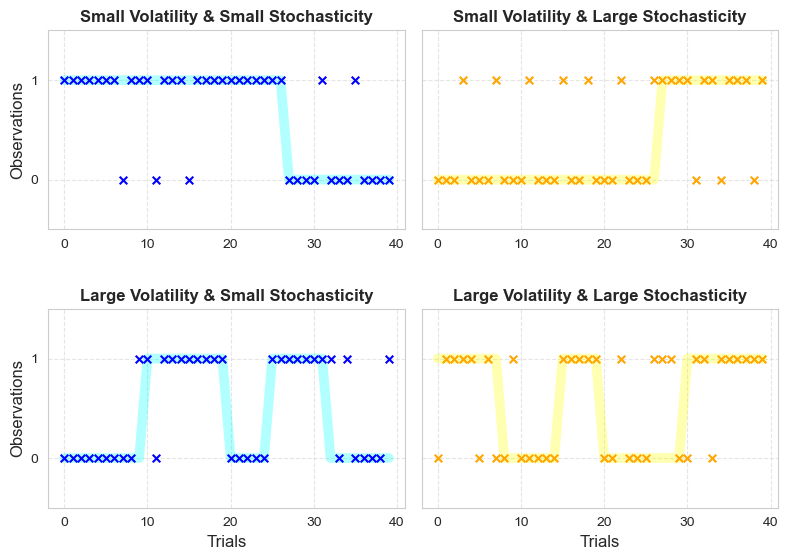

In [17]:
# Load observation data
file_path = os.path.join(mat_input_folder, "reward_stimuli.pkl")
obs_df = pd.read_pickle(file_path)
obs_df = pd.DataFrame(obs_df)

# Load hidden state data
file_path = os.path.join(mat_input_folder, "hidden_state.mat")
data = loadmat(file_path)
# print(data.keys())  # List variables in the .mat file
# print(len(data['timeseries'][0][0]))  # Get the shape of the variable 'timeseries'
hidden_state = data['timeseries'][0][0][4]  # Replace 'variable_name' with your actual variable name
# print(hidden_state)
# N = len(obs_df[0])
# true_vol = [0.025, 0.1, 0.025, 0.1]
# true_sto = [0.125, 0.125, 0.25, 0.25]

# Common plot styling
plot_kwargs = dict(linestyle='solid', linewidth=7, alpha=0.3)
scatter_kwargs = dict(marker='x', s=30, zorder=3)
grid_kwargs = dict(axis='both', linestyle='--', alpha=0.5)

# Subplot settings
titles = [
    'Small Volatility & Small Stochasticity',
    'Small Volatility & Large Stochasticity',
    'Large Volatility & Small Stochasticity',
    'Large Volatility & Large Stochasticity'
]

hidden_state_indices = [0, 2, 1, 3]
obs_colors = ['blue', 'orange', 'blue', 'orange']
line_colors = ['cyan', 'yellow', 'cyan', 'yellow']

# Create figure and subplots
fig, axs = plt.subplots(2, 2, figsize=(8, 6), sharex=False, sharey=True)

# Flatten the axes for easier looping
axs = axs.flatten()

for i, ax in enumerate(axs):
    # Plot line
    ax.plot(obs_df.index, hidden_state[:, hidden_state_indices[i]],
            color=line_colors[i], **plot_kwargs)
    
    # Scatter observed data
    ax.scatter(obs_df.index, obs_df[hidden_state_indices[i]],
               color=obs_colors[i], **scatter_kwargs)

    # Title and axis
    ax.set_title(titles[i], fontsize=TITLE_FONTSIZE, fontweight='bold')
    ax.set_ylim(-0.5, 1.5)
    ax.set_yticks([0, 1])
    ax.tick_params(axis='x', labelsize=TICK_FONTSIZE)
    ax.tick_params(axis='y', labelsize=TICK_FONTSIZE)
    ax.grid(**grid_kwargs)

    # X and Y labels where appropriate
    if i in [2, 3]:  # Bottom row
        ax.set_xlabel('Trials', fontsize=LABEL_FONTSIZE)
    if i in [0, 2]:  # Left column
        ax.set_ylabel('Observations', fontsize=LABEL_FONTSIZE)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.subplots_adjust(hspace=0.4)  # Adjust this value as needed
plt.savefig(save_path + "FigureSupp1_actual_timeseries.png", dpi=300, bbox_inches='tight')
plt.show()